In [ ]:
!pip install seaborn wordcloud nltk

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import zipfile
from collections import Counter
import os

In [ ]:
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Explore Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/sentiment-analysis-on-movie-reviews/train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


**The sentiment labels are:**
* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

In [ ]:
df['Sentiment'].unique()

array([1, 2, 3, 4, 0])

## Distribution sentiment classes

### Plot handlers

In [ ]:
def shpw_distplot(_df, feature):
    plt.figure(figsize=(8, 6))
    sns.distplot(_df[feature], bins=10, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.show()

In [ ]:
def generate_wordcloud(all_words, feature, label="Most used words in"):
    # Generate word cloud
    wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(all_words))

    # Plot word cloud
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.title(f"{label} {feature}", size=16)
    plt.axis("off")
    plt.show()

In [ ]:
def show_word_ferq(_df, feature, top_words=10):
  # Get the top 10 most common words
  words = ' '.join(_df[feature]).split()
  word_counts = Counter(words)
  top_words = word_counts.most_common(top_words)

  # Separate the words and their counts
  words, counts = zip(*top_words)

  # Create the bar plot
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
  ax1.bar(words, counts)
  ax1.set_title(f"{feature} Word Frequency")

  ax2.bar(words, np.log10(counts))
  ax2.set_title(f"{feature} Word Frequency (Log10 Adjusted)")
  plt.show()

In [ ]:
def getAllWords(_df, feature):
    return pd.Series(' '.join(str(_df[feature]).split()))

In [ ]:
def show_sentiment_distribution(_df, feature):
    # Count the occurrences of each unique sentiment category
    sentiment_counts = _df[feature].value_counts()

    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Sentiment Distribution')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Show the pie chart
    plt.show()

**Distribution Plot for Sentiment**

In [ ]:
feature_target = 'Sentiment'

<ipython-input-8-58e8588d5a6d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(_df[feature], bins=10, kde=True)


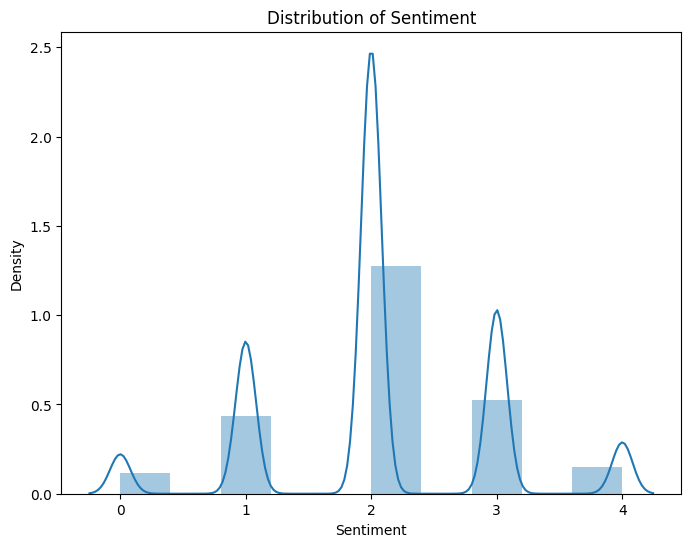

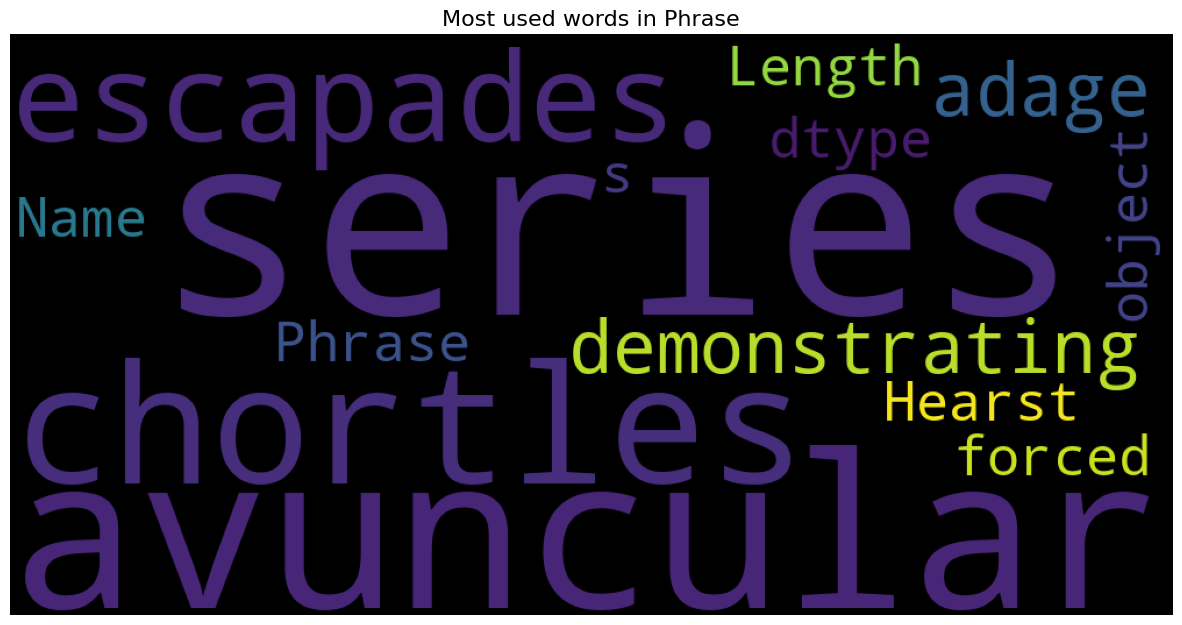

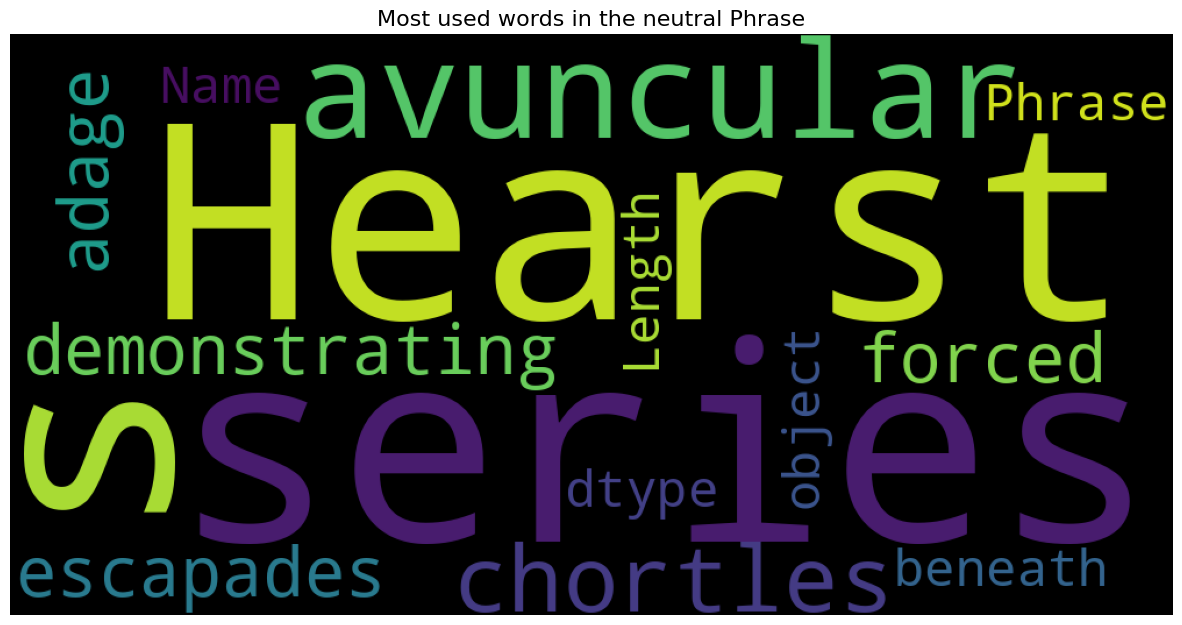

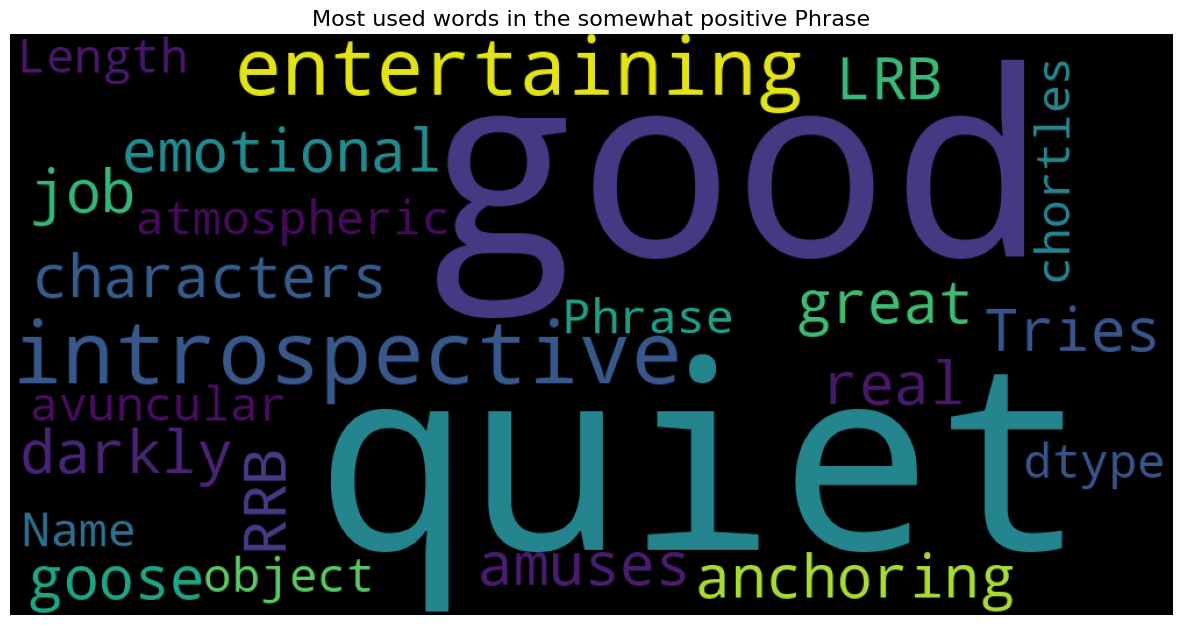

In [ ]:
shpw_distplot(df, feature_target)

# get all words for phrase column
all_words = getAllWords(df, 'Phrase')

# show the word cloud
generate_wordcloud(all_words, 'Phrase')

# get all words for neutral
all_words_neutral = getAllWords(df[df[feature_target] == 2], 'Phrase')

# show the word cloud for neutral
generate_wordcloud(all_words_neutral, 'Phrase', 'Most used words in the neutral')

# get all words for somewhat positive
all_words_somewhat_positive = getAllWords(df[df[feature_target] == 3], 'Phrase')

# show the word cloud for neutral
generate_wordcloud(all_words_somewhat_positive, 'Phrase', 'Most used words in the somewhat positive')

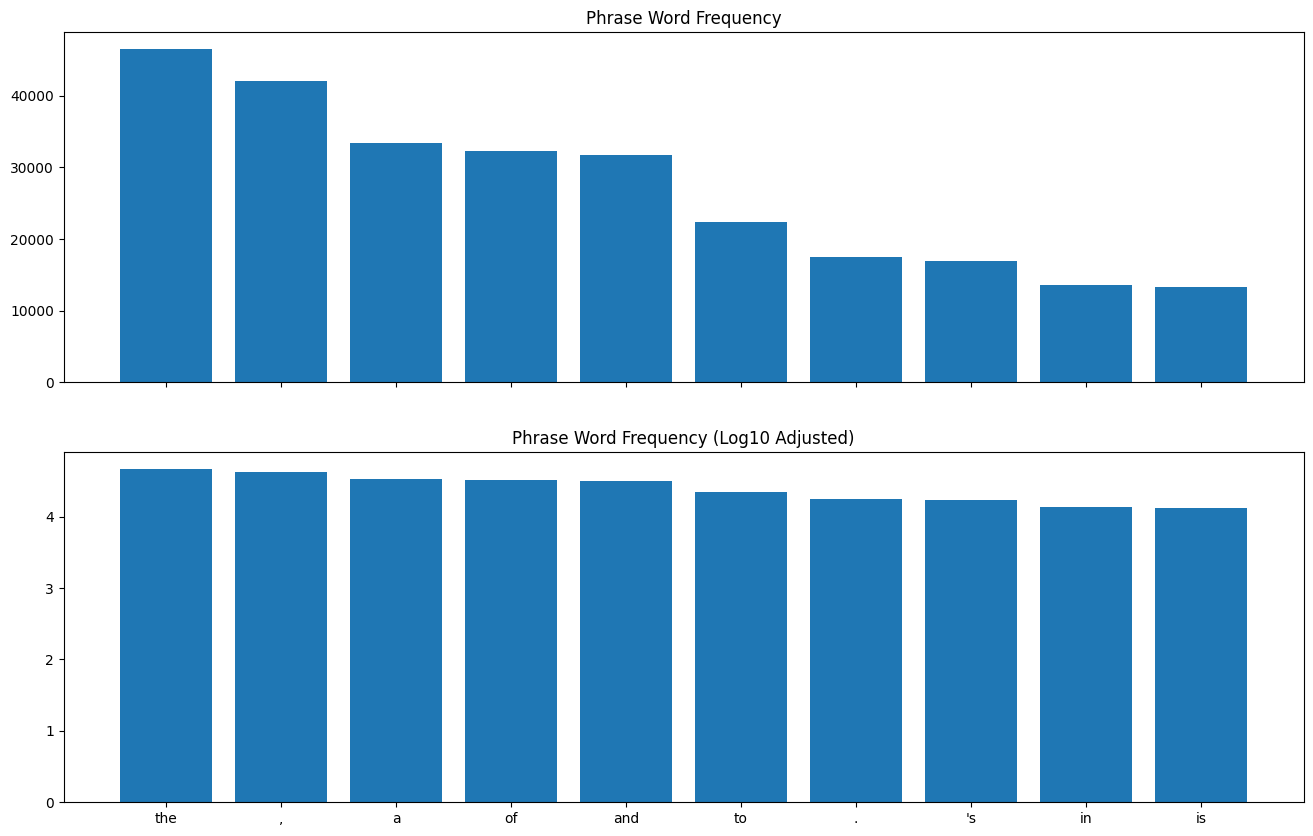

In [ ]:
show_word_ferq(df, 'Phrase')

we can see that there is ',' and '.' we should remove the stop words to see the words correctly

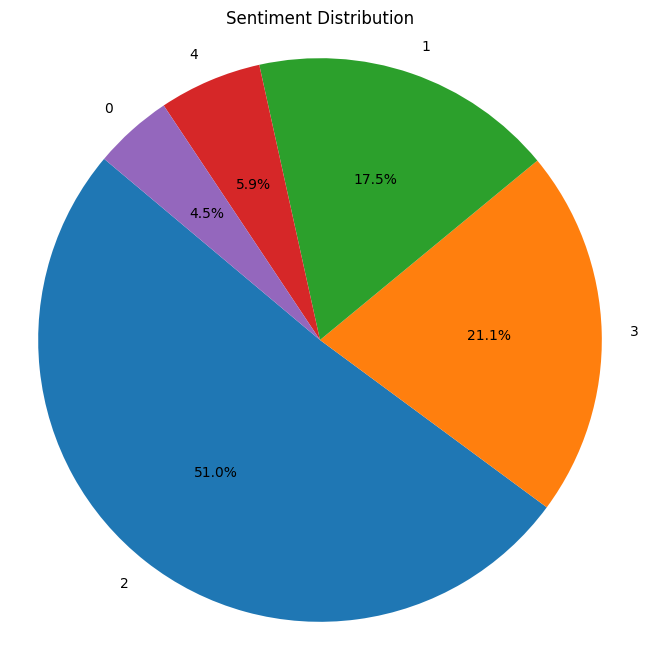

In [ ]:
show_sentiment_distribution(df, feature_target)

# Preprocess Data

## Preprocess utils handlers

### Check for nan handler

In [ ]:
# check_for_nan for many features
def check_for_nan(_df, features=[]):
    [print(f"{feature} has {_df[feature].isnull().sum()} nan") for feature in features]

### Remove stop words handler

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the stop words
nltk.download('stopwords')
nltk.download('punkt')

# Get the stop words for Arabic and English
stop_words = stopwords.words('english')

# Function to remove stop words from a string
def remove_stop_words(text):
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word.casefold() not in stop_words]
    return ' '.join(filtered)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Most common word handler

In [ ]:
def get_common_word(_df, feature):
  from collections import Counter
  reviews_without_null = _df[_df[feature].notnull()][feature]
  # Get the most common word in 'feature'
  words = pd.Series(' '.join(reviews_without_null).lower().split())
  return Counter(words).most_common(1)[0][0]

**check features for nan**

In [ ]:
features_labels = ['Phrase', 'Sentiment','SentenceId','PhraseId']
check_for_nan(df, features_labels)

Phrase has 0 nan
Sentiment has 0 nan
SentenceId has 0 nan
PhraseId has 0 nan


**apply stop words handler**

In [ ]:
df['Phrase'] = df['Phrase'].apply(remove_stop_words)

**Check most common word**

In [ ]:
most_common_word_review = get_common_word(df, 'Phrase')
print(most_common_word_review)

,


## Create two tensors (inputs IDs, Attension Mak)

In [ ]:
df['Phrase'][0]

'series escapades demonstrating adage good goose also good gander , occasionally amuses none amounts much story .'

In [ ]:
from transformers import BertTokenizer, AutoModel
model_name = 'bert-base-uncased'

**Create the tokenizer**

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Let’s apply the tokenizer to one sentence just to see the output.**

In [ ]:
sentance_sample = df['Phrase'][0]
# Print the original sentence.
print(' Original: ', sentance_sample)

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentance_sample))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentance_sample)))

 Original:  series escapades demonstrating adage good goose also good gander , occasionally amuses none amounts much story .
Tokenized:  ['series', 'es', '##cap', '##ades', 'demonstrating', 'ada', '##ge', 'good', 'goose', 'also', 'good', 'gan', '##der', ',', 'occasionally', 'am', '##uses', 'none', 'amounts', 'much', 'story', '.']
Token IDs:  [2186, 9686, 17695, 18673, 14313, 15262, 3351, 2204, 13020, 2036, 2204, 25957, 4063, 1010, 5681, 2572, 25581, 3904, 8310, 2172, 2466, 1012]


We are required to:

1. Add special tokens to the start and end of each sentence.
1. Pad & truncate all sentences to a single constant length.
1. Explicitly differentiate real tokens from padding tokens with the “attention mask”.

### Tokenize Dataset

**maximum sentence length**

In [ ]:
max_len = 0
sentences = df['Phrase']
# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  65


In [ ]:
# we will add 5 more for max sentence length to be 70
max_length = 70

Now we’re ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I’m using `tokenizer.encode_plus` to get the fifth item (attention masks).

**Tokenize all of the sentences and map the tokens to thier word IDs.**

In [ ]:
input_ids = []
attention_masks = []

# For every sentence ...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                         # Sentence to encode.
                        add_special_tokens=True,      # Add '[CLS]' and '[SEP]'
                        max_length=max_length,        # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True, # Construct attn. masks.
                        return_tensors = 'pt',        # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df[feature_target])

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  series escapades demonstrating adage good goose also good gander , occasionally amuses none amounts much story .
Token IDs: tensor([  101,  2186,  9686, 17695, 18673, 14313, 15262,  3351,  2204, 13020,
         2036,  2204, 25957,  4063,  1010,  5681,  2572, 25581,  3904,  8310,
         2172,  2466,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


### Training & Validation Split

In [ ]:
from torch.utils.data import random_split, TensorDataset, DataLoader, RandomSampler, SequentialSampler

**Divide up our training set to use 90% for training and 10% for validation.**

In [ ]:
# Combine the tranining inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create 90% - 10% train - validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

140,454 training samples
15,606 validation samples


**We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.**

In [ ]:
# The DataLoader needs to know our batch size for tranining, so we specify it here,
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32

batch_size = 32

# Create the DataLoader for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
        train_dataset,
        sampler = RandomSampler(train_dataset),# select batches randomly
        batch_size = batch_size
    )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
        val_dataset,
        sampler = SequentialSampler(val_dataset),# Pull out batches sequentially.
        batch_size = batch_size
    )

# Build And Train Our Classification Model

### BertForSequenceClassification
For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

Here is the current list of classes provided for fine-tuning:

- BertModel
- BertForPreTraining
- BertForMaskedLM
- BertForNextSentencePrediction
- **BertForSequenceClassification** - The one we’ll use.
- BertForTokenClassification
- BertForQuestionAnswering

In [ ]:
!pip install torch-summary

In [ ]:
from torchsummary import summary
from transformers import BertForSequenceClassification, AdamW,BertConfig, get_linear_schedule_with_warmup
import random

**Load the base BERT model**

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    model_name, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels=5,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In the below cell, I’ve printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### Optimizer & Learning Rate Scheduler
Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper):
> * Batch size: 16, 32
> * Learning rate (Adam): 5e-5, 3e-5, 2e-5
> * Number of epochs: 2, 3, 4

We chose:

* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we’ll see that this is probably too many…)

In [ ]:
lr = 2e-5
eps = 1e-8

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = eps # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the leaning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_training_steps=0,
                                           num_warmup_steps=total_steps)

### Training Loop

Below is our training loop.Fundamentally for each pass in our loop we have a trianing phase and a validation phase.

**Training:**

* Unpack our data inputs and labels

* Load data onto the GPU for acceleration

* Clear out the gradients calculated in the previous pass.

   - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
   

* Forward pass (feed input data through the network)

* Backward pass (backpropagation)

* Tell the network to update parameters with optimizer.step()

* Track variables for monitoring progress

**Evalution:**

* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring progress

**Define a helper function for calculating accuracy.**

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

**Helper function for formatting elapsed times as hh:mm:ss**

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch ...
for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training

    model.train()

    # For each batch for training data..
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print(' Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids,
                            token_type_ids= None,
                            attention_mask=b_input_mask,
                            labels= b_labels)
        loss = output['loss']
        logits = output['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            output = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        loss = output['loss']
        logits = output['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(" Accruacy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0 )

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append({
        'epoch': epoch_i+1,
        'Training Loss': avg_train_loss,
        'Valid Loss': avg_val_loss,
        'Valid Accur.':avg_val_accuracy,
        'Training Time':training_time,
        'Validation Time':validation_time

    })

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0 )))


======== Epoch 1 / 3 ========
Training...
 Batch    40 of 4,390. Elapsed: 0:00:15.
 Batch    80 of 4,390. Elapsed: 0:00:28.
 Batch   120 of 4,390. Elapsed: 0:00:42.
 Batch   160 of 4,390. Elapsed: 0:00:55.
 Batch   200 of 4,390. Elapsed: 0:01:09.
 Batch   240 of 4,390. Elapsed: 0:01:23.
 Batch   280 of 4,390. Elapsed: 0:01:37.
 Batch   320 of 4,390. Elapsed: 0:01:50.
 Batch   360 of 4,390. Elapsed: 0:02:05.
 Batch   400 of 4,390. Elapsed: 0:02:19.
 Batch   440 of 4,390. Elapsed: 0:02:33.
 Batch   480 of 4,390. Elapsed: 0:02:48.
 Batch   520 of 4,390. Elapsed: 0:03:02.
 Batch   560 of 4,390. Elapsed: 0:03:17.
 Batch   600 of 4,390. Elapsed: 0:03:32.
 Batch   640 of 4,390. Elapsed: 0:03:46.
 Batch   680 of 4,390. Elapsed: 0:04:01.
 Batch   720 of 4,390. Elapsed: 0:04:15.
 Batch   760 of 4,390. Elapsed: 0:04:30.
 Batch   800 of 4,390. Elapsed: 0:04:45.
 Batch   840 of 4,390. Elapsed: 0:04:59.
 Batch   880 of 4,390. Elapsed: 0:05:14.
 Batch   920 of 4,390. Elapsed: 0:05:29.
 Batch   960 o

KeyboardInterrupt: 

**Let’s view the summary of the training process.**

In [ ]:
training_stats

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Save Model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/sentiment-analysis-on-movie-reviews/resources/model1'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

### Load the model
with name `loaded_model`

In [ ]:
# loaded_model = BertForSequenceClassification.from_pretrained(output_dir)
loaded_model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/sentiment-analysis-on-movie-reviews/resources")
# Put model in evaluation mode
_ = loaded_model.eval()

### Test Data Preparation

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/sentiment-analysis-on-movie-reviews/test.tsv', sep='\t')
df.head()

In [ ]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

In [ ]:
def prep_data(texet):
    encoded_dict = tokenizer.encode_plus(
                        texet,                         # Sentence to encode.
                        add_special_tokens=True,      # Add '[CLS]' and '[SEP]'
                        max_length=max_length,        # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True, # Construct attn. masks.
                        return_tensors = 'pt',        # Return pytorch tensors.
        )
    # Convert the token into tensor
    input_ids = torch.cat([encoded_dict['input_ids']], dim=0)
    attention_masks = torch.cat([encoded_dict['attention_mask']], dim=0)

    batch_size = 32

    # Create the DataLoader.
    prediction_data = TensorDataset(input_ids, attention_masks)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

    return prediction_dataloader

In [ ]:
def get_sentiment_pred(score):
    sentiments={
        0 : 'negative',
        1 : 'somewhat negative',
        2 : 'neutral',
        3 : 'somewhat positive',
        4 : 'positive',
    }
    return sentiments[score]

In [ ]:
def pred(text):
    predictions = []
    prediction_dataloader = prep_data(text)
    # Predict
    for batch in prediction_dataloader:
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask = batch

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = loaded_model(b_input_ids, token_type_ids=None,
                          attention_mask=b_input_mask)

      logits = outputs[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()

      # Store predictions and true labels
      predictions.append(logits)

    pred = predictions[0][0]
    return {
        "score":np.argmax(pred),
        "text":text
    }

In [ ]:
def wrap_pred_output(score,text):
    sentiment_text = get_sentiment_pred(score)
    print(f" given text: '{text}' \n seems to be {sentiment_text} \n\n")

In [ ]:
wrap_pred_output(**pred("this movie is awesome"))
wrap_pred_output(**pred("this movie is terrible"))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 given text: 'this movie is awesome' 
 seems to be positive 


 given text: 'this movie is terrible' 
 seems to be negative 




In [ ]:
wrap_pred_output(**pred("this movie is okay"))

 given text: 'this movie is okay' 
 seems to be somewhat positive 




In [ ]:
wrap_pred_output(**pred("Animal Movie Review: Ranbir Kapoor Transforms Into A Wild Beast, Delivering A Career-Defining Performance"))

 given text: 'Animal Movie Review: Ranbir Kapoor Transforms Into A Wild Beast, Delivering A Career-Defining Performance' 
 seems to be positive 




In [ ]:
wrap_pred_output(**pred("WILL WATCH ON OTT only. When is it getting released on netflix ? & why the obsession with coal mines..god only knows."))

 given text: 'WILL WATCH ON OTT only. When is it getting released on netflix ? & why the obsession with coal mines..god only knows.' 
 seems to be somewhat negative 




In [ ]:
wrap_pred_output(**pred("Not upto the expectation ... getting bored of the black universe of Prasanth Neel ... thoose who have seen Ugram will not feel anything special..."))

 given text: 'Not upto the expectation ... getting bored of the black universe of Prasanth Neel ... thoose who have seen Ugram will not feel anything special...' 
 seems to be somewhat negative 




In [ ]:
wrap_pred_output(**pred("I watched this film in the nearest theater to my house. It's overall representation is quiet good, you'll love it. Action scenes are better than KGF, at least I felt that. But overall it's just good, not badass like KGF-1,2. Salaar doesn't hold the aura like KGF for sure, this film is more of drama/politics rather than action, there's 70%-75% drama and only 25%-30% action which quiet felt weird to me. In short this film lies in between the WORSE and the BADASS category. There're 2-3 iconic moments that you'll love it but I think it could have been more in the film. Overall the movie is good, it's not unwatchable, just don't compare it to KGF because that film is on another level.... "))

 given text: 'I watched this film in the nearest theater to my house. It's overall representation is quiet good, you'll love it. Action scenes are better than KGF, at least I felt that. But overall it's just good, not badass like KGF-1,2. Salaar doesn't hold the aura like KGF for sure, this film is more of drama/politics rather than action, there's 70%-75% drama and only 25%-30% action which quiet felt weird to me. In short this film lies in between the WORSE and the BADASS category. There're 2-3 iconic moments that you'll love it but I think it could have been more in the film. Overall the movie is good, it's not unwatchable, just don't compare it to KGF because that film is on another level.... ' 
 seems to be neutral 




In [ ]:
wrap_pred_output(**pred("Although I love the movie with a different perspectives like it shows as a genre of Hollywood like Indian movie that we could challenge Hollywood, and everything is for me as I love pure Cinema lover,and I'm never support bad movie but Salaar has best thing of drama,characters, emotions, fights,cinematography etc. Although Its my all time first choice to the Best Film ever Salaar for its content 😍from Assam I support Salaar like greatest cinema.... "))

 given text: 'Although I love the movie with a different perspectives like it shows as a genre of Hollywood like Indian movie that we could challenge Hollywood, and everything is for me as I love pure Cinema lover,and I'm never support bad movie but Salaar has best thing of drama,characters, emotions, fights,cinematography etc. Although Its my all time first choice to the Best Film ever Salaar for its content 😍from Assam I support Salaar like greatest cinema.... ' 
 seems to be somewhat positive 




In [ ]:
wrap_pred_output(**pred("Grand cinematography and best colour collection but film was so disappointed with story wise, acting, trying to present like kgf."))

 given text: 'Grand cinematography and best colour collection but film was so disappointed with story wise, acting, trying to present like kgf.' 
 seems to be somewhat negative 




In [ ]:
wrap_pred_output(**pred("""Story moves little bit slow for that last star.
Can watch with family, no vulgar scenes and no nonsense scenes...."""))

 given text: 'Story moves little bit slow for that last star.
Can watch with family, no vulgar scenes and no nonsense scenes....' 
 seems to be somewhat positive 




In [ ]:
df['Sentiment'] = None

In [ ]:
df['Sentiment'].shape

(156060,)

In [ ]:
for i, row in df.iterrows():
    score = pred(row['Phrase'])['score']
    df.at[i, 'Sentiment'] = score

KeyboardInterrupt: 

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
len(df[df['Sentiment']==2])

In [ ]:
len(df)

## Ref

[BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) (22 Jul 2019)